In [2]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from google.colab import files

uploaded_files = files.upload()
file = list(uploaded_files.keys())[0]


RANDOM_STATE = 42


# Loading Dataset Files
csv_path = file
df = pd.read_csv(csv_path)

print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

# Ensuring numeric core fields
for col in ["worldwide_gross", "production_budget", "profit_proxy", "roi_proxy",
            "tomatometer_rating", "tomatometer_count", "runtime", "star_power_score"]:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(r"[,$]", "", regex=True)
            .replace("", np.nan)
            .astype(float)
        )

Saving box_office_success_2015_2024_Updated.csv to box_office_success_2015_2024_Updated.csv
Data shape: (578, 25)
Columns: ['title', 'year', 'original_release_date_parsed', 'domestic_gross', 'international_gross', 'worldwide_gross', 'production_budget', 'profit_proxy', 'roi_proxy', 'tomatometer_rating', 'tomatometer_count', 'genres', 'runtime', 'directors', 'lead_actor', 'lead_actor_has_oscar', 'lead_actor_tier', 'lead_actor_status', 'star_power_score', 'is_animated', 'is_live_action', 'is_franchise', 'is_sequel', 'is_standalone', 'lead_actor_clean']


In [3]:
# Target: log(worldwide_gross)

df = df.dropna(subset=["worldwide_gross", "production_budget"]).copy()
df["log_worldwide_gross"] = np.log1p(df["worldwide_gross"])

print("Data shape after dropping missing gross/budget:", df.shape)

# Primary genre + label encodings
df["genres"] = df["genres"].fillna("Unknown")
df["primary_genre"] = df["genres"].str.split(",").str[0].str.lower().str.strip()

# Ordinal
#Label encoding for lead_actor_tier and lead_actor_status
tier_map = {"C": 0, "B": 1, "A": 2}
status_map = {"well_known": 0, "trending": 1}

df["lead_actor_tier_enc"] = df["lead_actor_tier"].map(tier_map)
df["lead_actor_status_enc"] = df["lead_actor_status"].map(status_map)

# Ensuring year is numeric
df["year"] = pd.to_numeric(df["year"], errors="coerce")

# High-cardinality
# Target encoding for directors, lead_actor
# Using mean of log_worldwide_gross (our regression target)

if "directors" in df.columns:
    dir_mean = df.groupby("directors")["log_worldwide_gross"].mean()
    df["director_te"] = df["directors"].map(dir_mean)
else:
    df["director_te"] = np.nan

if "lead_actor" in df.columns:
    actor_mean = df.groupby("lead_actor")["log_worldwide_gross"].mean()
    df["lead_actor_te"] = df["lead_actor"].map(actor_mean)
else:
    df["lead_actor_te"] = np.nan


# Defining X and y according to our spec
y = df["log_worldwide_gross"]

# excluding "worldwide_gross", to avoid leaking target into features
numeric_features = [
    "production_budget",
    "profit_proxy",
    "roi_proxy",
    "tomatometer_rating",
    "tomatometer_count",
    "runtime",
    "star_power_score",
    "year",
    # low-card categoricals treated as numeric/indicator
    "is_animated",
    "is_live_action",
    "is_franchise",
    "is_sequel",
    "is_standalone",
    "lead_actor_has_oscar",
    "lead_actor_tier_enc",
    "lead_actor_status_enc",
    # target-encoded high-card
    "director_te",
    "lead_actor_te",
]

categorical_features = [
    "primary_genre",  # one-hot
]

# Filter to columns that actually exist
numeric_features = [c for c in numeric_features if c in df.columns]
categorical_features = [c for c in categorical_features if c in df.columns]

X = df[numeric_features + categorical_features].copy()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("Final X shape:", X.shape, "y shape:", y.shape)

Data shape after dropping missing gross/budget: (578, 26)
Numeric features: ['production_budget', 'profit_proxy', 'roi_proxy', 'tomatometer_rating', 'tomatometer_count', 'runtime', 'star_power_score', 'year', 'is_animated', 'is_live_action', 'is_franchise', 'is_sequel', 'is_standalone', 'lead_actor_has_oscar', 'lead_actor_tier_enc', 'lead_actor_status_enc', 'director_te', 'lead_actor_te']
Categorical features: ['primary_genre']
Final X shape: (578, 19) y shape: (578,)


In [6]:

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


# Preprocessing: impute + scale numeric, impute + one-hot categorical
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


# Defining the models
# Models used: Ridge,RandomForest, and GradientBoost
models = {
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=3,
        random_state=RANDOM_STATE,
    ),
}

#  Test Evaluation with Cross-validation
results = []
fitted_pipes = {}

kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, model in models.items():
    print(f"\n=== {name} ===")

    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", model),
        ]
    )

    # --- Cross-validation (R^2) ---
    cv_scores_r2 = cross_val_score(
        pipe, X, y, cv=kfold, scoring="r2"
    )
    # --- Cross-validation (RMSE in log space) ---
    cv_scores_rmse_log = cross_val_score(
        pipe, X, y, cv=kfold, scoring="neg_root_mean_squared_error"
    )

    print(f"Cross-validation: R^2 mean: {cv_scores_r2.mean():.4f} ± {cv_scores_r2.std():.4f}")
    print(f"Cross-validation: RMSE_log mean: {-cv_scores_rmse_log.mean():.4f} ± {cv_scores_rmse_log.std():.4f}")

    # Fitting the model on train and evaluating on the held-out test set
    pipe.fit(X_train, y_train)
    #storing fitted model
    fitted_pipes[name] = pipe

    y_pred_test = pipe.predict(X_test)

    # Metrics on test in log space
    rmse_log_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)

    # Convert to dollar scale
    y_test_dollars = np.expm1(y_test)
    y_pred_dollars = np.expm1(y_pred_test)
    rmse_dollars_test = np.sqrt(mean_squared_error(y_test_dollars, y_pred_dollars))

    results.append(
        {
            "model": name,
            "cross-validation r2_mean": cv_scores_r2.mean(),
            "cross-validation rmse_log_mean": -cv_scores_rmse_log.mean(),
            "test r2": r2_test,
            "test rmse_log": rmse_log_test,
            "test rmse_dollars": rmse_dollars_test,
        }
    )

# summary table
results_df = pd.DataFrame(results).sort_values(by="test rmse_dollars")
print("\n Final Model Comparison (sorted by Test RMSE):")
print(results_df.to_string(index=False))

print("\n Final Model Comparison (sorted by Test RMSE):")
print(results_df.to_string(index=False))

Train size: 462
Test size: 116

=== Ridge ===
Cross-validation: R^2 mean: 0.9922 ± 0.0094
Cross-validation: RMSE_log mean: 0.0860 ± 0.0492

=== RandomForest ===
Cross-validation: R^2 mean: 0.9919 ± 0.0118
Cross-validation: RMSE_log mean: 0.0796 ± 0.0619

=== GradientBoosting ===
Cross-validation: R^2 mean: 0.9925 ± 0.0119
Cross-validation: RMSE_log mean: 0.0727 ± 0.0638

 Final Model Comparison (sorted by Test RMSE):
           model  cross-validation r2_mean  cross-validation rmse_log_mean  test r2  test rmse_log  test rmse_dollars
    RandomForest                  0.991859                        0.079576 0.968413       0.197037       6.477816e+07
GradientBoosting                  0.992495                        0.072725 0.968758       0.195958       6.893801e+07
           Ridge                  0.992206                        0.085968 0.973442       0.180672       7.216721e+07

 Final Model Comparison (sorted by Test RMSE):
           model  cross-validation r2_mean  cross-validatio

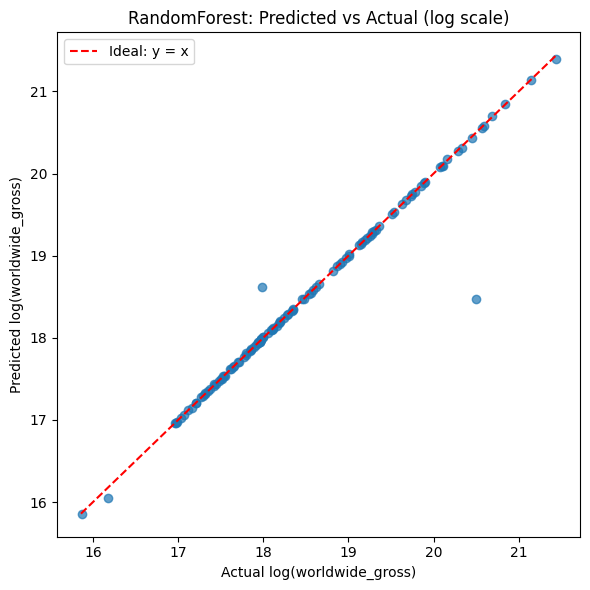

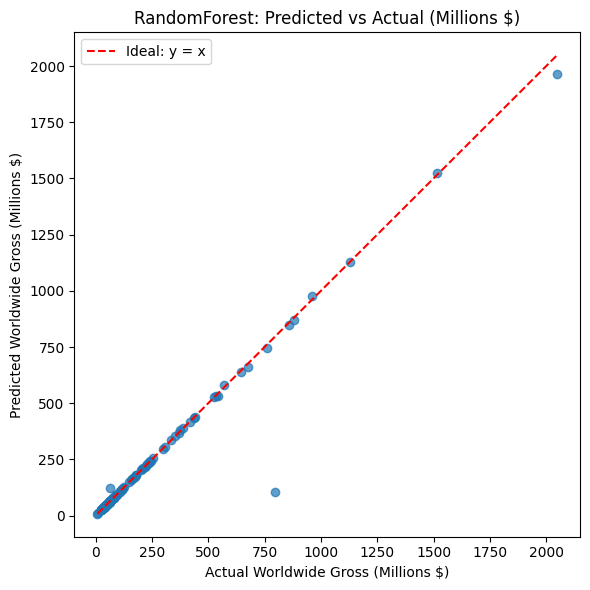

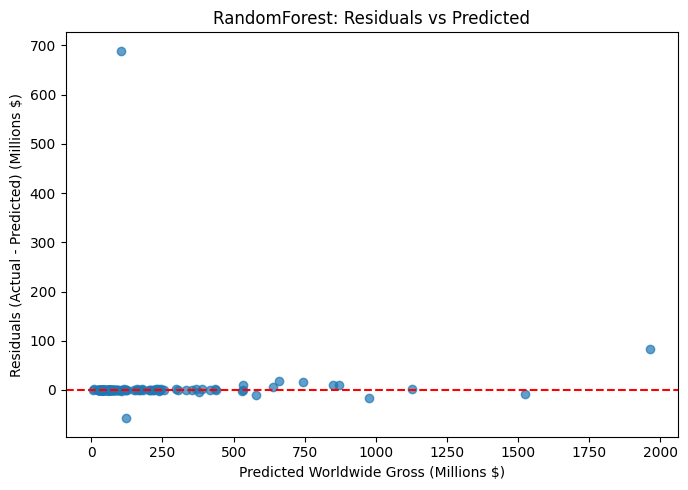

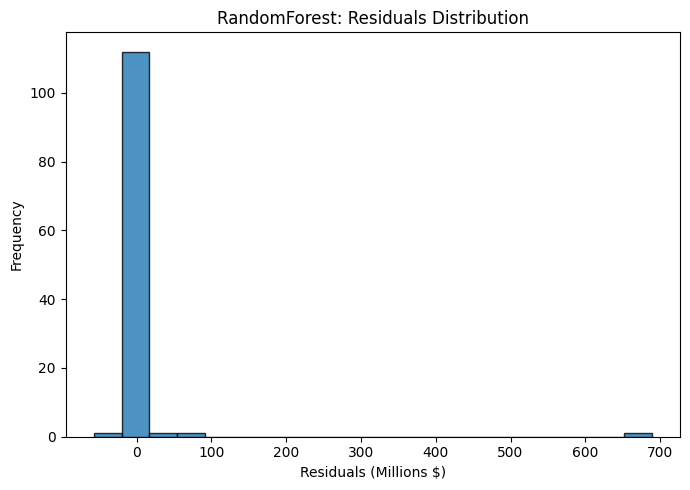


 Final Model Comparison (sorted by Test RMSE ) :
           model  cross-validation r2_mean  cross-validation rmse_log_mean  test r2  test rmse_log  test rmse_dollars
    RandomForest                  0.991859                        0.079576 0.968413       0.197037       6.477816e+07
GradientBoosting                  0.992495                        0.072725 0.968758       0.195958       6.893801e+07
           Ridge                  0.992206                        0.085968 0.973442       0.180672       7.216721e+07


In [7]:

# Evaluation plots for  RandomForest
chosen_model_name = "RandomForest"

pipe_best = fitted_pipes[chosen_model_name]

# Recompute predictions on test set
y_pred_test = pipe_best.predict(X_test)

# log-space
y_test_log = y_test
y_pred_log = y_pred_test

# dollar-space
y_test_dollars = np.expm1(y_test_log)
y_pred_dollars = np.expm1(y_pred_log)

# Predicted vs Actual (log scale)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_log, y_pred_log, alpha=0.7)
min_log = min(y_test_log.min(), y_pred_log.min())
max_log = max(y_test_log.max(), y_pred_log.max())
plt.plot([min_log, max_log], [min_log, max_log], "r--", label="Ideal: y = x")
plt.xlabel("Actual log(worldwide_gross)")
plt.ylabel("Predicted log(worldwide_gross)")
plt.title(f"{chosen_model_name}: Predicted vs Actual (log scale)")
plt.legend()
plt.tight_layout()
plt.show()

# Predicted vs Actual (dollars, in millions)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_dollars / 1e6, y_pred_dollars / 1e6, alpha=0.7)
min_val = min((y_test_dollars / 1e6).min(), (y_pred_dollars / 1e6).min())
max_val = max((y_test_dollars / 1e6).max(), (y_pred_dollars / 1e6).max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Ideal: y = x")
plt.xlabel("Actual Worldwide Gross (Millions $)")
plt.ylabel("Predicted Worldwide Gross (Millions $)")
plt.title(f"{chosen_model_name}: Predicted vs Actual (Millions $)")
plt.legend()
plt.tight_layout()
plt.show()

# Residuals vs Predicted (dollars)
residuals_dollars = y_test_dollars - y_pred_dollars

plt.figure(figsize=(7, 5))
plt.scatter(y_pred_dollars / 1e6, residuals_dollars / 1e6, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Worldwide Gross (Millions $)")
plt.ylabel("Residuals (Actual - Predicted) (Millions $)")
plt.title(f"{chosen_model_name}: Residuals vs Predicted")
plt.tight_layout()
plt.show()

# Residuals histogram
plt.figure(figsize=(7, 5))
plt.hist(residuals_dollars / 1e6, bins=20, edgecolor="black", alpha=0.8)
plt.xlabel("Residuals (Millions $)")
plt.ylabel("Frequency")
plt.title(f"{chosen_model_name}: Residuals Distribution")
plt.tight_layout()
plt.show()




print("\n Final Model Comparison (sorted by Test RMSE ) :")
print(results_df.to_string(index=False))

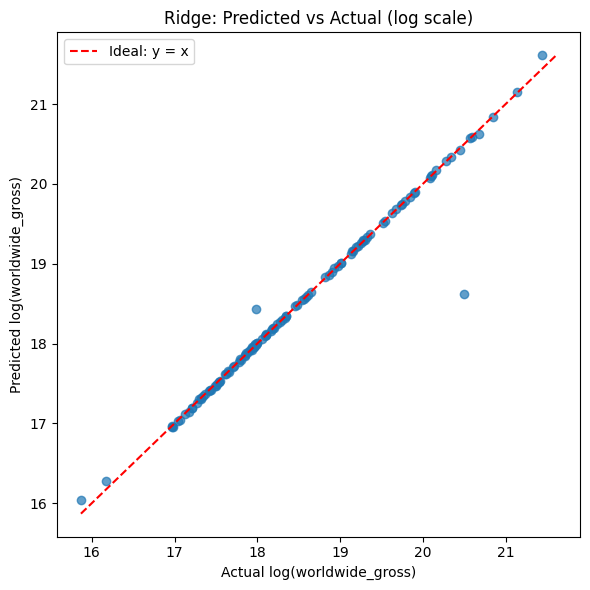

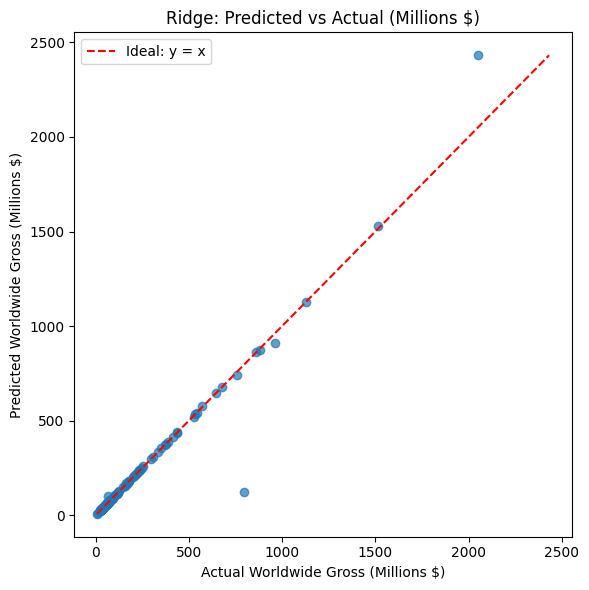

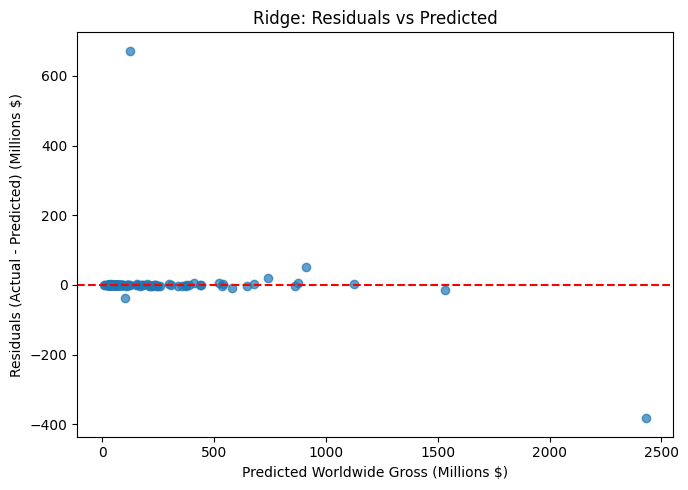

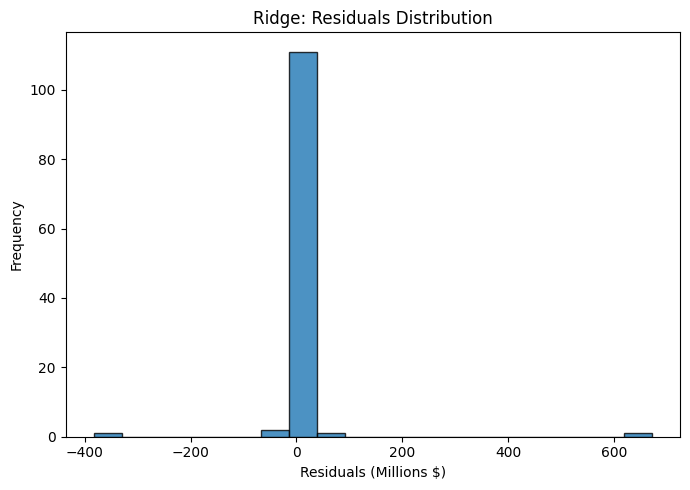


 Final Model Comparison (sorted by Test RMSE ) :
           model  cross-validation r2_mean  cross-validation rmse_log_mean  test r2  test rmse_log  test rmse_dollars
    RandomForest                  0.991859                        0.079576 0.968413       0.197037       6.477816e+07
GradientBoosting                  0.992495                        0.072725 0.968758       0.195958       6.893801e+07
           Ridge                  0.992206                        0.085968 0.973442       0.180672       7.216721e+07


In [8]:

# Evaluation plots for Ridge
chosen_model_name = "Ridge"

pipe_best = fitted_pipes[chosen_model_name]

# Recompute predictions on test set
y_pred_test = pipe_best.predict(X_test)

# log-space
y_test_log = y_test
y_pred_log = y_pred_test

# dollar-space
y_test_dollars = np.expm1(y_test_log)
y_pred_dollars = np.expm1(y_pred_log)

# Predicted vs Actual (log scale)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_log, y_pred_log, alpha=0.7)
min_log = min(y_test_log.min(), y_pred_log.min())
max_log = max(y_test_log.max(), y_pred_log.max())
plt.plot([min_log, max_log], [min_log, max_log], "r--", label="Ideal: y = x")
plt.xlabel("Actual log(worldwide_gross)")
plt.ylabel("Predicted log(worldwide_gross)")
plt.title(f"{chosen_model_name}: Predicted vs Actual (log scale)")
plt.legend()
plt.tight_layout()
plt.show()

# Predicted vs Actual (dollars, in millions)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_dollars / 1e6, y_pred_dollars / 1e6, alpha=0.7)
min_val = min((y_test_dollars / 1e6).min(), (y_pred_dollars / 1e6).min())
max_val = max((y_test_dollars / 1e6).max(), (y_pred_dollars / 1e6).max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Ideal: y = x")
plt.xlabel("Actual Worldwide Gross (Millions $)")
plt.ylabel("Predicted Worldwide Gross (Millions $)")
plt.title(f"{chosen_model_name}: Predicted vs Actual (Millions $)")
plt.legend()
plt.tight_layout()
plt.show()

# Residuals vs Predicted (dollars)
residuals_dollars = y_test_dollars - y_pred_dollars

plt.figure(figsize=(7, 5))
plt.scatter(y_pred_dollars / 1e6, residuals_dollars / 1e6, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Worldwide Gross (Millions $)")
plt.ylabel("Residuals (Actual - Predicted) (Millions $)")
plt.title(f"{chosen_model_name}: Residuals vs Predicted")
plt.tight_layout()
plt.show()

# Residuals histogram
plt.figure(figsize=(7, 5))
plt.hist(residuals_dollars / 1e6, bins=20, edgecolor="black", alpha=0.8)
plt.xlabel("Residuals (Millions $)")
plt.ylabel("Frequency")
plt.title(f"{chosen_model_name}: Residuals Distribution")
plt.tight_layout()
plt.show()




print("\n Final Model Comparison (sorted by Test RMSE ) :")
print(results_df.to_string(index=False))

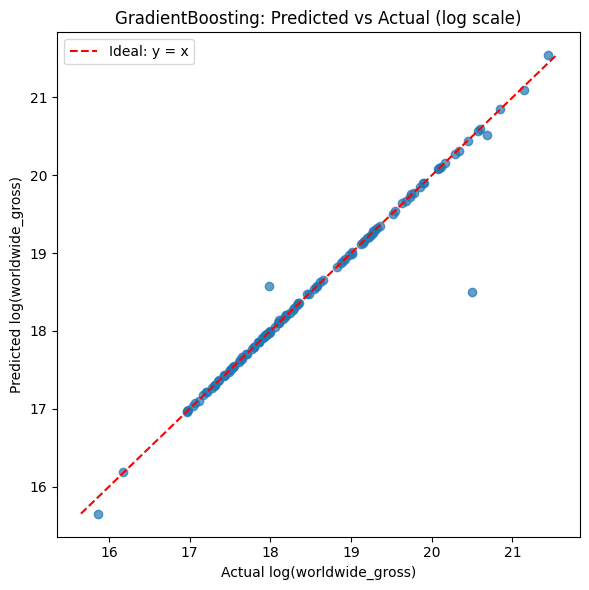

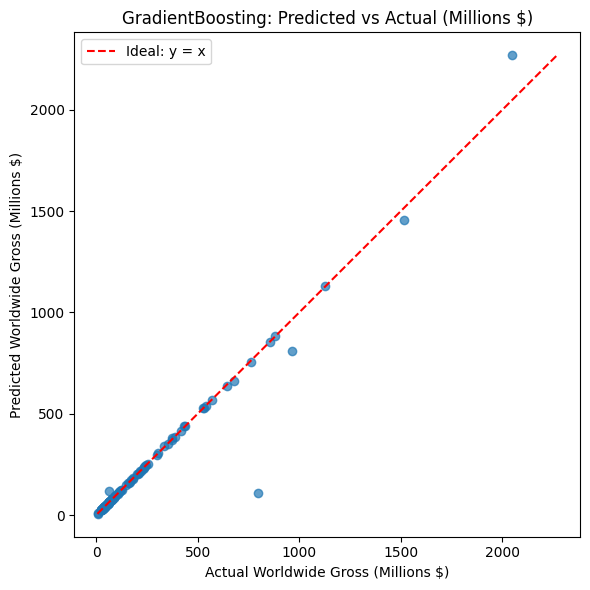

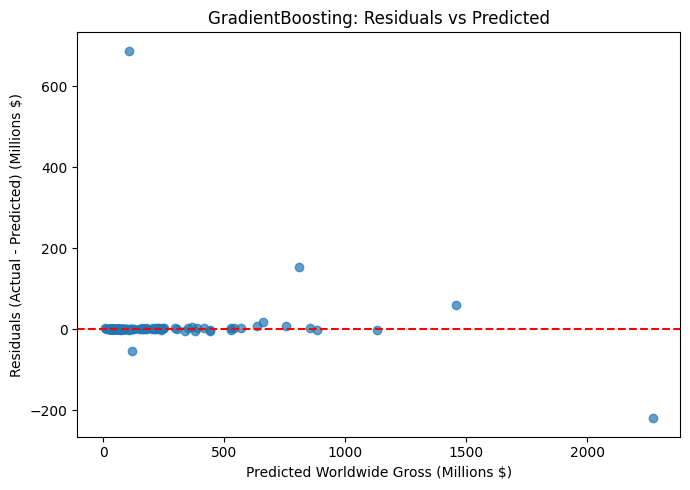

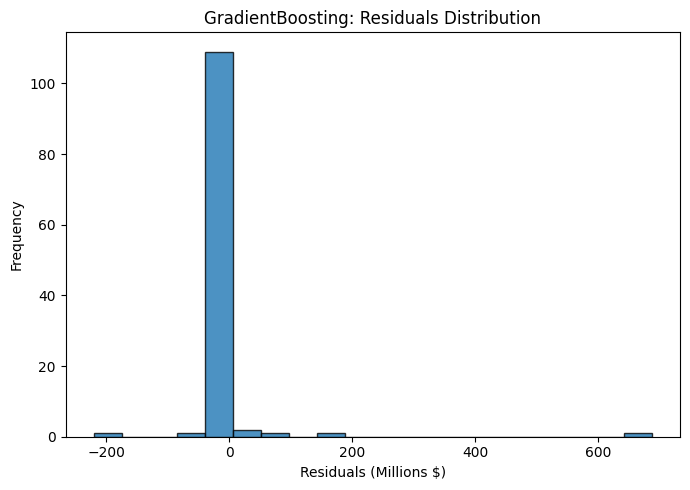


 Final Model Comparison (sorted by Test RMSE ) :
           model  cross-validation r2_mean  cross-validation rmse_log_mean  test r2  test rmse_log  test rmse_dollars
    RandomForest                  0.991859                        0.079576 0.968413       0.197037       6.477816e+07
GradientBoosting                  0.992495                        0.072725 0.968758       0.195958       6.893801e+07
           Ridge                  0.992206                        0.085968 0.973442       0.180672       7.216721e+07


In [10]:

# Evaluation plots for GradientBoosting
chosen_model_name = "GradientBoosting"

pipe_best = fitted_pipes[chosen_model_name]

# Recompute predictions on test set
y_pred_test = pipe_best.predict(X_test)

# log-space
y_test_log = y_test
y_pred_log = y_pred_test

# dollar-space
y_test_dollars = np.expm1(y_test_log)
y_pred_dollars = np.expm1(y_pred_log)

# Predicted vs Actual (log scale)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_log, y_pred_log, alpha=0.7)
min_log = min(y_test_log.min(), y_pred_log.min())
max_log = max(y_test_log.max(), y_pred_log.max())
plt.plot([min_log, max_log], [min_log, max_log], "r--", label="Ideal: y = x")
plt.xlabel("Actual log(worldwide_gross)")
plt.ylabel("Predicted log(worldwide_gross)")
plt.title(f"{chosen_model_name}: Predicted vs Actual (log scale)")
plt.legend()
plt.tight_layout()
plt.show()

# Predicted vs Actual (dollars, in millions)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_dollars / 1e6, y_pred_dollars / 1e6, alpha=0.7)
min_val = min((y_test_dollars / 1e6).min(), (y_pred_dollars / 1e6).min())
max_val = max((y_test_dollars / 1e6).max(), (y_pred_dollars / 1e6).max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Ideal: y = x")
plt.xlabel("Actual Worldwide Gross (Millions $)")
plt.ylabel("Predicted Worldwide Gross (Millions $)")
plt.title(f"{chosen_model_name}: Predicted vs Actual (Millions $)")
plt.legend()
plt.tight_layout()
plt.show()

# Residuals vs Predicted (dollars)
residuals_dollars = y_test_dollars - y_pred_dollars

plt.figure(figsize=(7, 5))
plt.scatter(y_pred_dollars / 1e6, residuals_dollars / 1e6, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Worldwide Gross (Millions $)")
plt.ylabel("Residuals (Actual - Predicted) (Millions $)")
plt.title(f"{chosen_model_name}: Residuals vs Predicted")
plt.tight_layout()
plt.show()

# Residuals histogram
plt.figure(figsize=(7, 5))
plt.hist(residuals_dollars / 1e6, bins=20, edgecolor="black", alpha=0.8)
plt.xlabel("Residuals (Millions $)")
plt.ylabel("Frequency")
plt.title(f"{chosen_model_name}: Residuals Distribution")
plt.tight_layout()
plt.show()




print("\n Final Model Comparison (sorted by Test RMSE ) :")
print(results_df.to_string(index=False))